# here we go

I use the code for feature generation from this kernel: https://www.kaggle.com/artgor/quick-and-dirty-regression.

## 0. Importing libraries

In [1]:
import re
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from typing import Any
from itertools import product
pd.set_option('max_rows', 500)
import re
from tqdm import tqdm
from joblib import Parallel, delayed

base_dir = 'data/'


## 1. Feature engineering

In [2]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv(base_dir + 'train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(base_dir + 'test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(base_dir + 'train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(base_dir + 'specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(base_dir + 'sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

# read data
train, test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


### encode_title

In [3]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code


# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

In [4]:
activity_game_titles = ['All Star Sorting', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Air Show', 'Crystals Rule', 'Bug Measurer (Activity)', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Watering Hole (Activity)', 'Dino Drink', 'Bubble Bath', 'Bottle Filler (Activity)', 'Dino Dive', 'Chow Time', 'Chicken Balancer (Activity)', 'Happy Camel', 'Leaf Leader', 'Pan Balance', 'Egg Dropper (Activity)']
game_titles = ['All Star Sorting', 'Air Show', 'Crystals Rule', 'Scrub-A-Dub', 'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time', 'Happy Camel', 'Leaf Leader', 'Pan Balance']
media_sequence = {'Welcome to Lost Lagoon!': 19, 'Tree Top City - Level 1':17, 'Ordering Spheres':61, 'Costume Box':61,'12 Monkeys':109, 'Tree Top City - Level 2':25, "Pirate's Tale":80, 
                  'Treasure Map':156, 'Tree Top City - Level 3':26, 'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18, 
                  'Balancing Act':72,'Lifting Heavy Things':118, 'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19, 'Heavy, Heavier, Heaviest':61}

### get_data

In [5]:
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    user_activities_time = {'Clip_time_mean':[], 'Activity_time_mean': [], 'Game_time_mean': []}
    
    positive_words = "play again|did it|job|wow|cool|nice|amazing|exactly|Great|awe|That's it|just right|good|Alright|gold|That's right|All right|right amount|Well done|you're right|happy|won|Whoa"
    negative_words = "try again|too|Almost|n't|but|Whoops|Oops|not right|Uh oh"
    accumulated_positive_events = 0
    accumulated_negative_events = 0
    accumulated_positive_title = {'accumulated_positive_'+t: 0 for t in activity_game_titles}
    accumulated_negative_title = {'accumulated_negative_'+t: 0 for t in activity_game_titles}
    accumulated_positive_title_ratio = {'accumulated_positive_ratio_'+t: 0 for t in activity_game_titles}
    accumulated_negative_title_ratio = {'accumulated_negative_ratio_'+t: 0 for t in activity_game_titles}
    accumulated_won_game = {'accumulated_won_game_count_'+g: 0 for g in game_titles}
    
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {e_c: 0 for e_c in list_of_event_code}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()}
    title_event_code_count: Dict[str, int] = {t_e: 0 for t_e in all_title_event_code}
    accumulated_correct_title = {'accumulated_correct_'+title: 0 for title in assess_titles}
    accumulated_uncorrect_title = {'accumulated_uncorrect_'+title: 0 for title in assess_titles}
    accumulated_accuracy_title = {'acc_mean_' + title: 0 for title in assess_titles}
    accumulated_accuracy_titles = {'acc_' + title: [] for title in assess_titles}
    
    time_spent_each_act = {t+"_time": 0 for t in list_of_user_activities}
    time_spent_each_acts = {t+"_time": [] for t in list_of_user_activities}
    time_spent_each_act_mean = {t+"_time_mean": 0 for t in list_of_user_activities}
    
    
    # itarates through each session of one installation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
    
        if (session_type=='Clip'):
            time_spent = media_sequence[session_title_text]
            user_activities_time[session_type+'_time_mean'].append(time_spent)
            time_spent_each_act[session_title_text + "_time"] += time_spent
            time_spent_each_acts[session_title_text + "_time"].append(time_spent)
        
        elif(session_type=='Activity' or session_type=='Game'):
            time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
            user_activities_time[session_type+'_time_mean'].append(time_spent)
            time_spent_each_act[session_title_text + "_time"] += time_spent
            time_spent_each_acts[session_title_text + "_time"].append(time_spent)
            
            sum_positive_events = session['event_data'].str.contains(positive_words, flags=re.IGNORECASE).sum()
            sum_negative_events = session['event_data'].str.contains(negative_words, flags=re.IGNORECASE).sum()
            accumulated_positive_events += sum_positive_events
            accumulated_negative_events += sum_negative_events
            accumulated_positive_title['accumulated_positive_'+session_title_text] += sum_positive_events
            accumulated_negative_title['accumulated_negative_'+session_title_text] += sum_negative_events
            p = accumulated_positive_title['accumulated_positive_'+session_title_text]
            n = accumulated_negative_title['accumulated_negative_'+session_title_text]
            accumulated_positive_title_ratio['accumulated_positive__ratio_'+session_title_text] = p/(p+n) if (p+n)>0 else 0
            accumulated_negative_title_ratio['accumulated_negative__ratio_'+session_title_text] = n/(p+n) if (p+n)>0 else 0
            
            if session_type == 'Game':
                accumulated_won_game['accumulated_won_game_count_'+session_title_text]+=session['event_data'].str.contains('play again', flags=re.IGNORECASE).sum()
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(accumulated_correct_title.copy())
            features.update(accumulated_uncorrect_title.copy())
            features.update(accumulated_accuracy_title.copy())
            features.update(accumulated_positive_title)
            features.update(accumulated_negative_title)
            features.update(accumulated_positive_title_ratio)
            features.update(accumulated_negative_title_ratio)
            features.update(accumulated_won_game.copy())
            features.update(time_spent_each_act.copy())
            features.update(time_spent_each_act_mean.copy())
            
            variety_features = [('var_title', title_count),
                                ('var_event_code', event_code_count),
                               ('var_title_event_code', title_event_code_count)]
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
            
            # positive & negative events
            features['accumulated_positive_events'] = accumulated_positive_events
            features['accumulated_negative_events'] = accumulated_negative_events
            positive_negative_events = accumulated_positive_events + accumulated_negative_events
            features['positive_events_ratio'] = accumulated_positive_events/positive_negative_events if positive_negative_events > 0 else 0
            features['negative_events_ratio'] = accumulated_negative_events/positive_negative_events if positive_negative_events > 0 else 0
            accumulated_positive_events = 0
            accumulated_negative_events = 0
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_title['accumulated_correct_'+session_title_text] += true_attempts
            accumulated_uncorrect_title['accumulated_uncorrect_'+session_title_text] += false_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
                features['accumulated_correct_duration'] = 0
                features['accumulated_uncorrect_duration'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                features['accumulated_correct_duration'] = features['accumulated_correct_attempts']/np.sum(durations)
                features['accumulated_uncorrect_duration'] = features['accumulated_uncorrect_attempts']/np.sum(durations)
            if user_activities_time['Clip_time_mean']==[]:
                features['Clip_time_mean'] = 0
                features['Clip_time_std'] = 0
            else:
                features['Clip_time_mean'] = np.mean(user_activities_time['Clip_time_mean'])
                features['Clip_time_std'] = np.std(user_activities_time['Clip_time_mean'])
            if user_activities_time['Activity_time_mean']==[]:
                features['Activity_time_mean'] = 0
                features['Activity_time_std'] = 0
            else:
                features['Activity_time_mean'] = np.mean(user_activities_time['Activity_time_mean'])
                features['Activity_time_std'] = np.std(user_activities_time['Activity_time_mean'])
            if user_activities_time['Game_time_mean']==[]:
                features['Game_time_mean'] = 0
                features['Game_time_std'] = 0
            else:
                features['Game_time_mean'] = np.mean(user_activities_time['Game_time_mean'])
                features['Game_time_std'] = np.std(user_activities_time['Game_time_mean'])
            time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
            time_spent_each_act[session_title_text + "_time"] += time_spent
            time_spent_each_acts[session_title_text + "_time"].append(time_spent)
            durations.append(time_spent)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            accumulated_accuracy_titles['acc_' + session_title_text].append(accuracy)
            if accumulated_accuracy_titles['acc_' + session_title_text]==[]:
                accumulated_accuracy_title['acc_mean_' + session_title_text] = 0
            else:
                accumulated_accuracy_title['acc_mean_' + session_title_text] = np.mean(accumulated_accuracy_titles['acc_' + session_title_text])
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
        
        event_code_count = update_counters(event_code_count, "event_code")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
        
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    
    return reduce_train, reduce_test, categoricals


# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

100%|██████████| 1000/1000 [02:26<00:00,  6.85it/s]


In [6]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
   
    return reduce_train, reduce_test

# call feature engineering function
reduce_train, reduce_test = preprocess(reduce_train, reduce_test)

In [7]:
print(reduce_train.shape)
print(reduce_test.shape)
print(categoricals)
# reduce_train.to_csv('reduce_train.csv', index=False)
# reduce_test.to_csv('reduce_test.csv', index=False)

(17690, 760)
(1000, 760)
['session_title']


In [8]:
# reduce_train = pd.read_csv('reduce_train0.csv')
# reduce_test = pd.read_csv('reduce_test0.csv')
# reduce_train.iloc[5353]['accuracy_group']
# reduce_train = reduce_train.copy().sample(frac=0.5)

In [8]:
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

# to_exclude = [] 
# ajusted_test = reduce_test.copy()
# for feature in ajusted_test.columns:
#     if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
#         data = reduce_train[feature]
#         train_mean = data.mean()
#         data = ajusted_test[feature] 
#         test_mean = data.mean()
#         try:
#             error = stract_hists(feature, adjust=True)
#             ajust_factor = train_mean / test_mean
#             if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
#                 to_exclude.append(feature)
#                 print(feature, train_mean, test_mean, error)
#             else:
#                 ajusted_test[feature] *= ajust_factor
#         except:
#             to_exclude.append(feature)
#             print(feature, train_mean, test_mean)

features = [x for x in features if x not in (to_remove)]
reduce_train[features].shape

1: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434878118
2: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.9965084543995759
3: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733654
4: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
5: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068793
6: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434878118
7: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146713992
8: FEAT_A: 2050 FEAT_B: accumulated_positive_Scrub-A-Dub - Correlation: 0.9952342543487924
9: FEAT_A: 4230 FEAT_B: 4235 - Correlation: 0.9999995197498746
10: FEAT_A: 4230 FEAT_B: Bubble Bath_4230 - Correlation: 0.9999999999999998
11: FEAT_A: 4230 FEAT_B: Bubble Bath_4235 - Correlation: 0.9999995197498746
12: FEAT_A: 5000 FEAT_B: 5010 - Correlation: 0.9991849213605333
13: FEAT_A: 5000 FEAT_B: Watering Hole (Activity)_5010 - Correlation: 0.9991849213605333
14: FEAT_A: 5000 FEAT_B: Watering Hole (Act

94: FEAT_A: Cart Balancer (Assessment)_3121 FEAT_B: Cart Balancer (Assessment)_2030 - Correlation: 1.0
95: FEAT_A: Cart Balancer (Assessment)_3121 FEAT_B: Cart Balancer (Assessment)_2010 - Correlation: 0.999849464604504
96: FEAT_A: Chest Sorter (Assessment)_3120 FEAT_B: Chest Sorter (Assessment)_3020 - Correlation: 0.9972489515829078
97: FEAT_A: Chest Sorter (Assessment)_3120 FEAT_B: accumulated_uncorrect_Chest Sorter (Assessment) - Correlation: 0.9972434688333254
98: FEAT_A: Bottle Filler (Activity)_2030 FEAT_B: Bottle Filler (Activity)_2020 - Correlation: 0.998817689964623
99: FEAT_A: Dino Dive_3010 FEAT_B: Dino Dive_3110 - Correlation: 0.9998637945770242
100: FEAT_A: All Star Sorting_3020 FEAT_B: All Star Sorting_2025 - Correlation: 0.9999983835744551
101: FEAT_A: All Star Sorting_3020 FEAT_B: All Star Sorting_3120 - Correlation: 0.9979692879543319
102: FEAT_A: All Star Sorting_3020 FEAT_B: accumulated_negative_All Star Sorting - Correlation: 0.9995085966685365
103: FEAT_A: Bubble B

(17690, 489)

In [9]:
features.extend(['accuracy_group', 'installation_id'])
reduce_train = reduce_train[features]
# reduce_test = ajusted_test
reduce_test = reduce_test[features]
reduce_train.shape

(17690, 491)

## 2. model

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True


class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

    
def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class CatWrapper(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = cat.CatBoostClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_cols'})

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_param('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)


class XGBWrapper(object):
    """
    A wrapper for xgboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = xgb.XGBClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_metric=eval_qwk_xgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        scores = self.model.evals_result()
        self.best_score_ = {k: {m: m_v[-1] for m, m_v in v.items()} for k, v in scores.items()}
        self.best_score_ = {k: {m: n if m != 'cappa' else -n for m, n in v.items()} for k, v in self.best_score_.items()}

        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)




class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [11]:
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')


In [12]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=None, drop_original: bool = False, encoder=OrdinalEncoder()):
        """
        Categorical transformer. This is a wrapper for categorical encoders.

        :param cat_cols:
        :param drop_original:
        :param encoder:
        """
        self.cat_cols = cat_cols
        self.drop_original = drop_original
        self.encoder = encoder
        self.default_encoder = OrdinalEncoder()

    def fit(self, X, y=None):

        if self.cat_cols is None:
            kinds = np.array([dt.kind for dt in X.dtypes])
            is_cat = kinds == 'O'
            self.cat_cols = list(X.columns[is_cat])
        self.encoder.set_params(cols=self.cat_cols)
        self.default_encoder.set_params(cols=self.cat_cols)

        self.encoder.fit(X[self.cat_cols], y)
        self.default_encoder.fit(X[self.cat_cols], y)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        new_cat_names = [f'{col}_encoded' for col in self.cat_cols]
        encoded_data = self.encoder.transform(data[self.cat_cols])
        if encoded_data.shape[1] == len(self.cat_cols):
            data[new_cat_names] = encoded_data
        else:
            pass

        if self.drop_original:
            data = data.drop(self.cat_cols, axis=1)
        else:
            data[self.cat_cols] = self.default_encoder.transform(data[self.cat_cols])

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

## 3. train & test

Fold 1 started at Tue Dec 31 12:36:31 2019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.899925	train's cappa: 0.684455	valid's rmse: 0.979483	valid's cappa: 0.612543
[200]	train's rmse: 0.83021	train's cappa: 0.742466	valid's rmse: 0.973415	valid's cappa: 0.613464
Early stopping, best iteration is:
[156]	train's rmse: 0.857316	train's cappa: 0.72106	valid's rmse: 0.972144	valid's cappa: 0.619095
Fold 2 started at Tue Dec 31 12:36:37 2019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.898381	train's cappa: 0.685915	valid's rmse: 0.983755	valid's cappa: 0.612294
[200]	train's rmse: 0.830761	train's cappa: 0.740863	valid's rmse: 0.977745	valid's cappa: 0.615248
Early stopping, best iteration is:
[126]	train's rmse: 0.87783	train's cappa: 0.703294	valid's rmse: 0.979675	valid's cappa: 0.617659
Fold 3 started at Tue Dec 31 12:36:40 2019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse

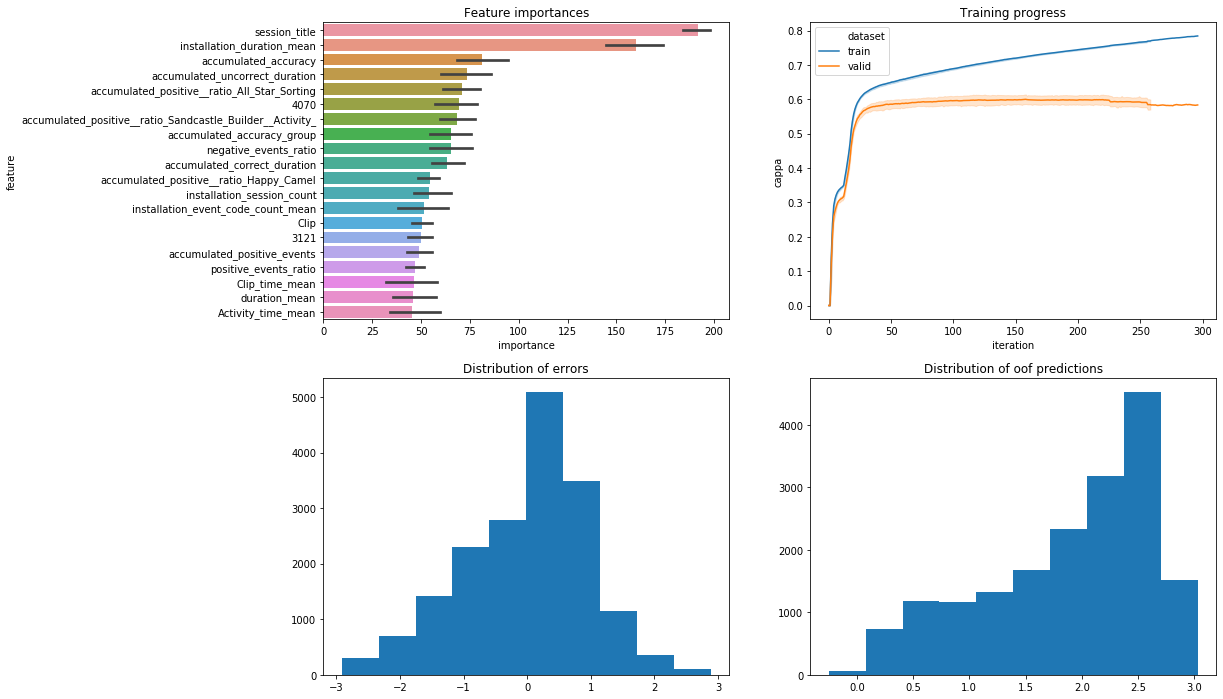

In [13]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 
            'eval_metric': 'cappa'
            }

# solve: LightGBMError: Do not support special JSON characters in feature name.
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]


y = reduce_train['accuracy_group']
n_fold = 5
folds = GroupKFold(n_splits=n_fold)
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']
mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=reduce_train, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)


In [14]:
reduce_train.shape

(17690, 491)

In [15]:
# print(regressor_model1.feature_importances['importance'].mean())
# importance = regressor_model1.feature_importances.groupby(['feature'])['importance'].mean().sort_values(ascending=False).head(300)
# print(list(importance.index))


In [16]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [23]:
%%time
pr1 = regressor_model1.predict(reduce_train)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()
# coefficients = [1.253629671522606, 1.697962321814793, 1.9425373198379534]
# dist = Counter(reduce_train['accuracy_group'])
# for k in dist:
#     dist[k] /= len(reduce_train)
# reduce_train['accuracy_group'].hist()
# acum = 0
# bound = [0, 0, 0]
# for i in range(3):
#     acum += dist[i]
#     bound[i] = np.percentile(pr1, acum * 100)
# coefficients = bound
print(coefficients)

# coefficients = [1.2614043207566141, 1.6603066679104515, 1.8960011870210187]
# coefficients = [1.30, 1.83925866, 2.155] 0.543

# coefficients = [1.30, 1.83925866, 2.154] 0.544
# coefficients = [1.5256, 1.898, 2.154] 0.535
# coefficients = [1.364, 1.83925866, 2.154] 0.545
# coefficients = [1.369, 1.83925866, 2.154] 0.545
# coefficients = [1.369, 1.845, 2.154] 0.544
# coefficients = [1.369, 1.841, 2.154] 0.545
# coefficients = [1.40, 1.841, 2.154] 0.542
# coefficients = [1.32, 1.83925866, 2.154] 0.542


# 
# coefficients = [1.263, 1.77, 2.025] 0.534
# coefficients = [1.16253215,1.71532098,2.17071483] 0.544
# coefficients = [1.16253215,1.71532098,2.07071483] 0.543
# coefficients = [1.16253215,1.71532098,2.10071483] 0.542
# coefficients = [1.18253215,1.71532098,2.17071483] 0.544
coefficients = [1.18253215,1.81532098,2.17071483]

opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

# some coefficients calculated by me.
pr1 = regressor_model1.predict(reduce_test[features])
# print(pr1)
# pr1[pr1 <= 1.12232214] = 0
# pr1[np.where(np.logical_and(pr1 > 1.12232214, pr1 <= 1.73925866))] = 1
# pr1[np.where(np.logical_and(pr1 > 1.73925866, pr1 <= 2.22506454))] = 2
# pr1[pr1 > 2.22506454] = 3
pr1[pr1 <= coefficients[0]] = 0
pr1[np.where(np.logical_and(pr1 > coefficients[0], pr1 <= coefficients[1]))] = 1
pr1[np.where(np.logical_and(pr1 > coefficients[1], pr1 <= coefficients[2]))] = 2
pr1[pr1 > coefficients[2]] = 3

sample_submission['accuracy_group'] = pr1.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)

[0.5479507  1.70262158 2.22604959]


KeyError: "['Scrub_A_Dub_3020', '2010', '5000', 'Cauldron_Filler__Assessment__4070', 'accumulated_won_game_count_Happy_Camel', '4095', 'Sandcastle_Builder__Activity__4080', 'Pan_Balance_4100', 'Bottle_Filler__Activity__3110', '2000', 'All_Star_Sorting_4030', 'All_Star_Sorting_3120', 'Fireworks__Activity__4030', 'Chow_Time_4035', 'Bottle_Filler__Activity__2030', 'Dino_Drink_2070', 'Bottle_Filler__Activity__4070', 'All_Star_Sorting_4095', 'Chest_Sorter__Assessment__4100', '4031', 'accumulated_negative_Fireworks__Activity_', '4110', 'Cart_Balancer__Assessment__4080', 'accumulated_negative_Dino_Drink', 'acc_Mushroom_Sorter__Assessment_', 'Air_Show_3120', 'Crystals_Rule', 'Bubble_Bath_4070', '2070', 'Chicken_Balancer__Activity__3010', 'Dino_Dive_time', 'Bird_Measurer__Assessment__2010', 'Watering_Hole__Activity__2010', 'Chest_Sorter__Assessment__2020', 'Bug_Measurer__Activity__4035', 'Bottle_Filler__Activity__2000', 'Pan_Balance_2030', 'accumulated_positive__ratio_All_Star_Sorting', 'accumulated_positive_Bubble_Bath', 'Bird_Measurer__Assessment__3110', 'Dino_Dive_2070', 'Crystal_Caves___Level_3', 'Cart_Balancer__Assessment__4090', 'Happy_Camel_4040', 'accumulated_negative_Crystals_Rule', 'Chicken_Balancer__Activity__4090', 'Bottle_Filler__Activity__4020', 'Mushroom_Sorter__Assessment__3010', 'Cart_Balancer__Assessment__4040', 'Dino_Dive_4010', 'Bird_Measurer__Assessment__4100', 'Watering_Hole__Activity_', 'Sandcastle_Builder__Activity__2000', '4050', 'accumulated_negative__ratio_Pan_Balance', 'acc_mean_Cart_Balancer__Assessment_', 'Sandcastle_Builder__Activity__4020', 'Bubble_Bath_2020', 'Air_Show_time', 'Mushroom_Sorter__Assessment__4090', 'Welcome_to_Lost_Lagoon_', 'Happy_Camel_2080', 'Chow_Time_2020', 'Bug_Measurer__Activity__time', 'Dino_Drink_3020', 'Dino_Dive_2060', 'accumulated_won_game_count_Bubble_Bath', 'Crystals_Rule_4010', 'Bird_Measurer__Assessment__4025', 'Leaf_Leader_3010', 'Leaf_Leader_4095', 'Flower_Waterer__Activity__4030', 'accumulated_negative_Bug_Measurer__Activity_', 'Chest_Sorter__Assessment__4080', 'Mushroom_Sorter__Assessment__3020', 'acc_mean_Mushroom_Sorter__Assessment_', 'Bug_Measurer__Activity__4025', 'Chicken_Balancer__Activity_', 'Chest_Sorter__Assessment__4035', 'Heavy__Heavier__Heaviest', 'Mushroom_Sorter__Assessment__4020', 'Flower_Waterer__Activity_', 'Bug_Measurer__Activity__4090', 'Cauldron_Filler__Assessment__4100', 'accumulated_negative_Watering_Hole__Activity_', 'Balancing_Act', 'Magma_Peak___Level_2', 'Leaf_Leader_2020', '4220', 'Cauldron_Filler__Assessment__2010', 'Sandcastle_Builder__Activity_', 'Chest_Sorter__Assessment__4020', '4021', 'Sandcastle_Builder__Activity__4090', 'Magma_Peak___Level_1', 'Crystal_Caves___Level_1', 'Leaf_Leader_3120', 'Bubble_Bath_2080', '2050', 'Air_Show_4110', 'Dino_Dive', 'Honey_Cake', '2060', 'Fireworks__Activity__4070', 'Mushroom_Sorter__Assessment__2000', 'Leaf_Leader_time', 'Cauldron_Filler__Assessment__4090', 'Flower_Waterer__Activity__time', 'Tree_Top_City___Level_1', '0', 'Cart_Balancer__Assessment__3021', 'Sandcastle_Builder__Activity__4030', 'Chow_Time_3020', '2', 'Chow_Time_4090', 'Happy_Camel_4035', 'Flower_Waterer__Activity__3110', 'accumulated_correct_Cauldron_Filler__Assessment_', 'accumulated_negative_Pan_Balance', 'Cart_Balancer__Assessment__4030', 'Dino_Drink_time', 'Egg_Dropper__Activity__time', 'Happy_Camel_3120', 'Leaf_Leader_4010', 'accumulated_negative__ratio_Dino_Dive', 'accumulated_negative__ratio_Egg_Dropper__Activity_', 'Happy_Camel_4030', 'Chicken_Balancer__Activity__4080', 'accumulated_positive__ratio_Air_Show', 'Happy_Camel', '3120', 'Scrub_A_Dub_3110', 'Mushroom_Sorter__Assessment__4040', '4022', '2075', 'accumulated_positive_Fireworks__Activity_', 'Mushroom_Sorter__Assessment__4080', 'accumulated_negative__ratio_Bubble_Bath', 'Cauldron_Filler__Assessment__4080', 'accumulated_positive_Chicken_Balancer__Activity_', 'Chicken_Balancer__Activity__4035', 'Leaf_Leader', 'Bird_Measurer__Assessment__4030', 'Happy_Camel_4010', 'Bubble_Bath_4095', 'Tree_Top_City___Level_2', 'Bird_Measurer__Assessment__time', 'Pan_Balance_time', 'Chow_Time_4095', 'accumulated_positive__ratio_Happy_Camel', 'Bubble_Bath_3010', 'All_Star_Sorting_4035', '4035', 'Bird_Measurer__Assessment_', 'Egg_Dropper__Activity__3110', 'accumulated_negative__ratio_Leaf_Leader', 'Cauldron_Filler__Assessment_', 'Cart_Balancer__Assessment__4020', 'Air_Show_2070', 'Cart_Balancer__Assessment__3010', 'Cart_Balancer__Assessment__3110', 'accumulated_positive_Air_Show', 'Egg_Dropper__Activity__4090', 'Crystal_Caves___Level_2', 'Dino_Dive_3120', 'acc_Chest_Sorter__Assessment_', 'Mushroom_Sorter__Assessment__4100', 'accumulated_negative__ratio_All_Star_Sorting', 'Scrub_A_Dub_2083', 'acc_Cart_Balancer__Assessment_', 'Leaf_Leader_4080', 'Happy_Camel_time', 'Air_Show_4020', 'accumulated_positive_Chow_Time', 'Happy_Camel_2020', 'Chicken_Balancer__Activity__4020', 'Bird_Measurer__Assessment__2020', 'Dino_Dive_3021', 'Dino_Dive_4020', 'Bottle_Filler__Activity__time', 'Chow_Time_3110', 'Cart_Balancer__Assessment__2010', 'Mushroom_Sorter__Assessment__4035', 'Pan_Balance', 'accumulated_positive_Bottle_Filler__Activity_', 'Leaf_Leader_4090', 'Air_Show_3021', 'Egg_Dropper__Activity__4020', 'Leaf_Leader_3121', 'Bubble_Bath_2083', 'accumulated_negative__ratio_Chicken_Balancer__Activity_', 'Egg_Dropper__Activity__4025', 'Scrub_A_Dub_2081', 'Mushroom_Sorter__Assessment_', 'Bird_Measurer__Assessment__4070', 'accumulated_positive__ratio_Fireworks__Activity_', 'Pan_Balance_2000', 'Chicken_Balancer__Activity__time', 'Chest_Sorter__Assessment__time', '4230', '2080', 'Dino_Dive_4070', 'Watering_Hole__Activity__4025', 'acc_Cauldron_Filler__Assessment_', 'accumulated_negative_Happy_Camel', 'Dino_Dive_2020', 'Dino_Drink_3010', 'Cauldron_Filler__Assessment__time', 'Cart_Balancer__Assessment__4070', 'Pan_Balance_4080', 'accumulated_negative__ratio_Happy_Camel', 'All_Star_Sorting', 'Scrub_A_Dub_4020', '4020', 'Costume_Box', 'Cauldron_Filler__Assessment__3020', 'All_Star_Sorting_4090', '4070', 'accumulated_positive_Leaf_Leader', 'All_Star_Sorting_4010', 'accumulated_positive__ratio_Scrub_A_Dub', 'Scrub_A_Dub_4090', 'Air_Show_2075', 'accumulated_negative__ratio_Scrub_A_Dub', 'accumulated_negative__ratio_Dino_Drink', 'Air_Show_4070', 'Fireworks__Activity_', 'Cauldron_Filler__Assessment__2030', 'Happy_Camel_2081', 'accumulated_negative_Air_Show', 'accumulated_negative__ratio_Crystals_Rule', 'Egg_Dropper__Activity__4080', 'accumulated_positive__ratio_Bottle_Filler__Activity_', 'Bird_Measurer__Assessment__4035', '3110', 'Sandcastle_Builder__Activity__4021', 'Bubble_Bath_4010', 'Cauldron_Filler__Assessment__4020', 'Happy_Camel_2000', 'Happy_Camel_4045', 'Mushroom_Sorter__Assessment__2035', 'Treasure_Map', '4030', 'Happy_Camel_4080', 'Chow_Time_2000', 'Chow_Time_time', 'Bubble_Bath_3120', 'Bubble_Bath_4090', 'accumulated_positive__ratio_Bubble_Bath', '2020', 'Bottle_Filler__Activity__4035', 'All_Star_Sorting_time', 'Cauldron_Filler__Assessment__4040', '2025', 'Scrub_A_Dub_2000', 'Crystals_Rule_4070', 'Air_Show_4100', 'Fireworks__Activity__time', 'Bird_Measurer__Assessment__4020', 'Dino_Drink_4020', 'Fireworks__Activity__2000', 'accumulated_negative__ratio_Sandcastle_Builder__Activity_', 'All_Star_Sorting_3110', 'Flower_Waterer__Activity__4080', 'Crystals_Rule_3120', 'Dino_Drink_2000', '4100', 'accumulated_uncorrect_Cauldron_Filler__Assessment_', 'Chest_Sorter__Assessment__4040', 'Leaf_Leader_2060', 'Sandcastle_Builder__Activity__4035', 'Fireworks__Activity__3010', 'Bug_Measurer__Activity__4030', 'accumulated_positive__ratio_Dino_Dive', 'accumulated_uncorrect_Cart_Balancer__Assessment_', 'Pirate_s_Tale', 'Dino_Drink_2075', 'Bottle_Filler__Activity__4080', 'Egg_Dropper__Activity__4070', '4010', 'Bubble_Bath_time', 'All_Star_Sorting_4020', '4080', 'accumulated_correct_Mushroom_Sorter__Assessment_', 'Air_Show_4010', 'Bubble_Bath_3021', 'Watering_Hole__Activity__2000', 'accumulated_negative_Chow_Time', 'Chow_Time_4080', 'Bird_Measurer__Assessment__2030', 'Dino_Dive_2030', 'Air_Show_2020', 'accumulated_negative__ratio_Bug_Measurer__Activity_', '2083', 'Chicken_Balancer__Activity__4070', 'Cart_Balancer__Assessment__4035', 'Happy_Camel_4070', 'Fireworks__Activity__4090', 'accumulated_positive__ratio_Sandcastle_Builder__Activity_', 'Happy_Camel_4095', 'Pan_Balance_4010', 'accumulated_positive__ratio_Flower_Waterer__Activity_', 'accumulated_negative_Bottle_Filler__Activity_', 'Crystals_Rule_2030', 'Watering_Hole__Activity__4070', 'Bubble_Bath_4080', 'Pan_Balance_3020', 'Chicken_Balancer__Activity__4022', 'Pan_Balance_4090', 'Slop_Problem', 'Bird_Measurer__Assessment__4110', 'Dino_Drink_2020', 'Chest_Sorter__Assessment__4090', 'Pan_Balance_4020', '2035', 'Dino_Drink', 'Pan_Balance_4030', 'Crystals_Rule_4020', 'Bug_Measurer__Activity__2000', 'All_Star_Sorting_4080', 'All_Star_Sorting_2020', 'Leaf_Leader_2075', 'Chow_Time_2030', 'Chow_Time_4010', 'accumulated_negative_Sandcastle_Builder__Activity_', 'Bubble_Bath_2000', 'Air_Show_4090', 'accumulated_negative__ratio_Chow_Time', 'Dino_Drink_4080', 'Lifting_Heavy_Things', 'Dino_Drink_2060', 'Scrub_A_Dub_2080', 'Chicken_Balancer__Activity__4030', 'Happy_Camel_3121', 'Crystals_Rule_time', 'Leaf_Leader_4020', 'Dino_Drink_3021', 'accumulated_positive__ratio_Dino_Drink', 'Air_Show_2060', 'accumulated_positive__ratio_Chicken_Balancer__Activity_', 'acc_Bird_Measurer__Assessment_', 'Happy_Camel_4020', 'Air_Show_2000', 'Bubble_Bath_2025', 'accumulated_positive__ratio_Crystals_Rule', 'Bird_Measurer__Assessment__4040', 'Bottle_Filler__Activity__4090', 'Pan_Balance_4070', 'All_Star_Sorting_2030', 'accumulated_negative__ratio_Flower_Waterer__Activity_', 'Crystals_Rule_2000', '1', 'Dino_Dive_4090', 'acc_mean_Bird_Measurer__Assessment_', 'Ordering_Spheres', 'Cauldron_Filler__Assessment__2000', 'accumulated_positive_Flower_Waterer__Activity_', 'Bottle_Filler__Activity_', 'acc_mean_Cauldron_Filler__Assessment_', 'accumulated_positive__ratio_Pan_Balance', 'Air_Show_3010', '3', 'accumulated_negative__ratio_Watering_Hole__Activity_', 'Cart_Balancer__Assessment__time', '4045', 'accumulated_negative__ratio_Bottle_Filler__Activity_', 'Chow_Time', 'Chicken_Balancer__Activity__2000', 'Flower_Waterer__Activity__4022', 'Chest_Sorter__Assessment__3021', 'Mushroom_Sorter__Assessment__4070', 'Flower_Waterer__Activity__4090', 'Cauldron_Filler__Assessment__4035', 'Air_Show', 'Scrub_A_Dub_time', 'Bubble_Bath', 'Flower_Waterer__Activity__4025', 'Mushroom_Sorter__Assessment__2010', 'Dino_Dive_3110', 'Bug_Measurer__Activity__3110', 'Leaf_Leader_2070', 'Flower_Waterer__Activity__4070', 'Bug_Measurer__Activity__4070', 'Cauldron_Filler__Assessment__2020', '12_Monkeys', 'acc_mean_Chest_Sorter__Assessment_', 'Chest_Sorter__Assessment__3010', 'accumulated_negative_Scrub_A_Dub', 'Egg_Dropper__Activity_', 'Scrub_A_Dub', 'Watering_Hole__Activity__time', 'Chest_Sorter__Assessment__2010', '4090', 'Sandcastle_Builder__Activity__4070', 'accumulated_negative_Egg_Dropper__Activity_', 'Egg_Dropper__Activity__2000', 'Happy_Camel_3110', 'Scrub_A_Dub_4070', '4025', 'Chest_Sorter__Assessment__3120', 'Watering_Hole__Activity__4021', 'accumulated_negative__ratio_Fireworks__Activity_', 'Crystals_Rule_4090', 'Watering_Hole__Activity__3110', 'accumulated_positive_Happy_Camel', 'accumulated_negative_Chicken_Balancer__Activity_', 'accumulated_positive__ratio_Leaf_Leader', 'Pan_Balance_3110', 'Cart_Balancer__Assessment__2020', 'Happy_Camel_2083', 'Scrub_A_Dub_4010', 'Bubble_Bath_4040', 'Fireworks__Activity__4020', 'Chest_Sorter__Assessment__4025', 'Dino_Drink_4070', '2081', '4040', 'Happy_Camel_4090', 'Flower_Waterer__Activity__2000', 'Sandcastle_Builder__Activity__time', 'Flower_Waterer__Activity__4020', 'Dino_Drink_4010', 'Pan_Balance_4035', 'Mushroom_Sorter__Assessment__time', 'Fireworks__Activity__4080', 'Chow_Time_4070', 'Bird_Measurer__Assessment__2000', 'Cart_Balancer__Assessment_', 'Chest_Sorter__Assessment__4030', 'Bird_Measurer__Assessment__4090', 'Cauldron_Filler__Assessment__3110', 'accumulated_negative__ratio_Air_Show', 'accumulated_positive__ratio_Chow_Time', 'Leaf_Leader_2000', 'Chest_Sorter__Assessment_', '3121', 'Leaf_Leader_4070', 'Chow_Time_4020', 'Dino_Drink_4090', 'Chow_Time_3010', 'Tree_Top_City___Level_3', 'Pan_Balance_4025', 'Bird_Measurer__Assessment__3121', 'Chow_Time_4030', 'Bug_Measurer__Activity__4080', 'Dino_Dive_2000', 'Dino_Dive_4080', 'Bug_Measurer__Activity_', 'Cauldron_Filler__Assessment__4025', 'All_Star_Sorting_4070', 'Mushroom_Sorter__Assessment__4030', 'Watering_Hole__Activity__4090', 'Chest_Sorter__Assessment__4070', 'Cart_Balancer__Assessment__4100', 'Sandcastle_Builder__Activity__3110', 'Dino_Drink_4030', 'Cart_Balancer__Assessment__3020', 'Bird_Measurer__Assessment__4080'] not in index"

## end